In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [2]:
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, make_scorer
from sklearn.datasets import fetch_20newsgroups
import gensim

### Import cleaned datasets

In [3]:
df_train = pd.read_csv('/Users/jsong/Documents/durg-recommendation/df_train.csv')
df_test = pd.read_csv('/Users/jsong/Documents/durg-recommendation/df_test.csv')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148387 entries, 0 to 148386
Data columns (total 5 columns):
drugName       148387 non-null object
condition      148387 non-null object
rating         148387 non-null float64
usefulCount    148387 non-null int64
review         148386 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 5.7+ MB


In [5]:
df_train.dropna(inplace=True)

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49175 entries, 0 to 49174
Data columns (total 5 columns):
drugName       49175 non-null object
condition      49175 non-null object
rating         49175 non-null float64
usefulCount    49175 non-null int64
review         49173 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 1.9+ MB


In [7]:
df_test.dropna(inplace=True)

In [8]:
from wordcloud import WordCloud

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(10,8), 
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color='white',
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
        
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

In [9]:
top_words=df_train.review.value_counts(normalize=True)[:40].keys()

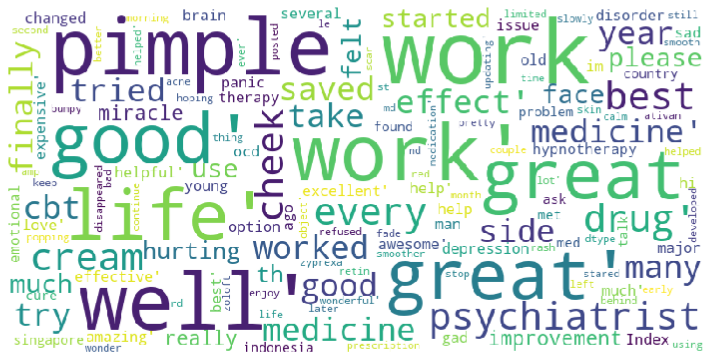

In [10]:
plot_wordcloud(top_words)
plt.savefig('/Users/jsong/Documents/durg-recommendation/fig/wordcloud.svg')

In [11]:
df_train.rating.value_counts(normalize=True)

10.0    0.310609
9.0     0.170993
1.0     0.134743
8.0     0.117450
7.0     0.058981
5.0     0.050402
2.0     0.043906
3.0     0.041318
6.0     0.039802
4.0     0.031795
Name: rating, dtype: float64

In [12]:
# Remove 4-7 star reviews
df_train2 = df_train.drop(df_train[(df_train['rating'] > 4.0) & (df_train['rating'] < 6.0)].index)

# Set 8-10 star reviews to positive(1), the rest to negative(0)
df_train2['sentiment'] = np.where(df_train2['rating'] >= 7, '1', '0')

df_train2

,drugName,condition,rating,usefulCount,review,sentiment
0,Guanfacine,ADHD,8.0,192,son halfway fourth intuniv became concerned be...,1
2,Ortho Evra,Birth Control,8.0,10,first time using form birth control glad went ...,1
3,Cialis,Benign Prostatic Hyperplasia,2.0,43,nd started work rock hard erection however exp...,0
4,Levonorgestrel,Emergency Contraception,1.0,5,pulled cummed bit took plan b hour later took ...,0
5,Aripiprazole,Bipolar Disorde,10.0,32,abilify changed life hope zoloft clonidine fir...,1
...,...,...,...,...,...,...
148382,Junel 1.5 / 30,Birth Control,6.0,0,would second junel birth control year changed ...,0
148383,Metoclopramide,Nausea/Vomiting,1.0,34,given surgey immediately became anxious could ...,0
148384,Orencia,Rheumatoid Arthritis,2.0,35,limited improvement month developed bad rash m...,0
148385,Thyroid desiccated,Underactive Thyroid,10.0,79,thyroid medication year spent first synthroid ...,1


In [13]:
# Remove 4-7 star reviews
df_test2 = df_test.drop(df_test[(df_test['rating'] > 4.0) & (df_test['rating'] < 6.0)].index)

# Set 8-10 star reviews to positive(1), the rest to negative(0)
df_test2['sentiment'] = np.where(df_test2['rating'] >= 7, '1', '0')

In [14]:
# Note that the dataset has mostly positive reviews
df_train2.sentiment.value_counts(normalize=True)

1    0.692961
0    0.307039
Name: sentiment, dtype: float64

In [15]:
export_csv = df_train2.to_csv(r'/Users/jsong/Documents/durg-recommendation/df_train_sentiment.csv', index = None, header=True)
export_csv = df_test2.to_csv(r'/Users/jsong/Documents/durg-recommendation/df_test_sentiment.csv', index = None, header=True)

In [16]:
X_train=df_train2.review
y_train=df_train2.sentiment
X_test=df_test2.review
y_test=df_test2.sentiment

In [17]:
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
n = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't",
     "mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in n:
    stop.remove(i)

a = ['mg', 'week', 'month', 'day', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 
     'august', 'september','october','november','december', 'iv','oral','pound',]
for j in a:
    stop.add(j)

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(stop_words=stop, ngram_range=(1, 1), min_df=10, max_df=0.7)

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()

,aa,aarp,ab,abacavir,abate,abated,abcess,abd,abdomen,abdominal,...,zovirax,zpack,zpak,zumba,zutripro,zyban,zyclara,zyprexa,zyrtec,zyvox
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=10, max_df=0.7)

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()

,aa,aarp,ab,abacavir,abate,abated,abcess,abd,abdomen,abdomen area,...,zutripro,zyban,zyban quit,zyclara,zyprexa,zyprexa made,zyprexa year,zyrtec,zyrtec claritin,zyvox
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Logistic Regression

In [20]:
lr = LogisticRegression()
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

/Users/jsong/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [21]:
# Train the second model
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

In [22]:
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

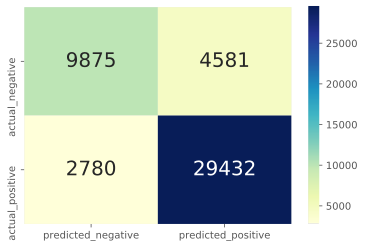

In [23]:
cm1=conf_matrix(y_test, y_pred_cv1)
plt.savefig('/Users/jsong/Documents/durg-recommendation/fig/cm1_lr1.svg')

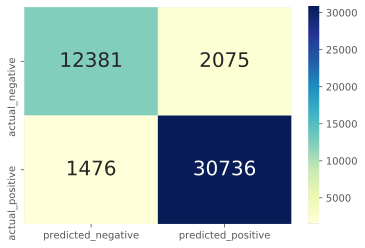

In [24]:
cm2=conf_matrix(y_test, y_pred_cv2)
plt.savefig('/Users/jsong/Documents/durg-recommendation/fig/cm2_lr2.svg')

In [25]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']
results

,LogReg1,LogReg2
Accuracy,0.842,0.924
Precision,0.865,0.937
Recall,0.914,0.954
F1 Score,0.889,0.945


### Naive Bayes

In [ ]:
# Fit the first Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_cv1, y_train)

y_pred_cv1_nb = mnb.predict(X_test_cv1)

In [ ]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train_cv2, y_train)

y_pred_cv2_nb = bnb.predict(X_test_cv2)

In [ ]:
# Here's the heat map for the first Naive Bayes model
cm3 = conf_matrix(y_test, y_pred_cv1_nb)
plt.savefig('/Users/jsong/Documents/durg-recommendation/fig/cm3_nb1.svg')

In [ ]:
# Here's the heat map for the second Naive Bayes model
cm4 = conf_matrix(y_test, y_pred_cv2_nb)
# plt.savefig('/Users/jsong/Documents/durg-recommendation/fig/cm4_nb2.svg')

In [ ]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm3, cm4)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['NB1', 'NB2']
results_nb

results = pd.concat([results, results_nb], axis=1)
results

### Try using TF-IDF instead of Count Vectorizer

In [ ]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words=stop, ngram_range=(1, 1), min_df=10, max_df=0.7)
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

In [ ]:
tfidf2 = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=10, max_df=0.7)
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

In [ ]:
# Fit the first logistic regression on the TF-IDF data
lr.fit(X_train_tfidf1, y_train)
y_pred_tfidf1_lr = lr.predict(X_test_tfidf1)
cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)
plt.savefig('/Users/jsong/Documents/durg-recommendation/fig/cm5_tf_idf_lr1.svg')

In [ ]:
# Fit the second logistic regression on the TF-IDF data
lr.fit(X_train_tfidf2, y_train)
y_pred_tfidf2_lr = lr.predict(X_test_tfidf2)
cm6 = conf_matrix(y_test, y_pred_tfidf2_lr)
plt.savefig('/Users/jsong/Documents/durg-recommendation/fig/cm6_tf_idf_lr2.svg')

In [ ]:
# Fit the first Naive Bayes model on the TF-IDF data
mnb.fit(X_train_tfidf1.toarray(), y_train)
y_pred_tfidf1_nb = mnb.predict(X_test_tfidf1)
cm8 = conf_matrix(y_test, y_pred_tfidf1_nb)
plt.savefig('/Users/jsong/Documents/durg-recommendation/fig/cm8_tf_idf_nb1.svg')

In [ ]:
# # Fit the second Naive Bayes model on the TF-IDF data
bnb.fit(X_train_tfidf2.toarray(), y_train)
y_pred_tfidf2_nb = bnb.predict(X_test_tfidf2)
cm9 = conf_matrix(y_test, y_pred_tfidf2_nb)
plt.savefig('/Users/jsong/Documents/durg-recommendation/fig/cm9_tf_idf_nb2.svg')

In [ ]:
# Compile all of the error metrics into a dataframe for comparison
results_tf = pd.DataFrame(list(zip(cm5, cm6, cm8, cm9)))
results_tf = results_tf.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_tf.columns = ['LR1-TFIDF', 'LR2-TFIDF', 'NB1-TFIDF', 'NB2-TFIDF']
results_tf

results = pd.concat([results, results_tf], axis=1)
results